### Exercise on Cosmology, PSI 2024
### author Djordje Mijovic

### First thing we want to do here is to import some packages and data.

In [1]:
# Importing packages

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
import emcee
import getdist
from getdist import plots, MCSamples

# Loading SGC and NGC SNIa data

data_sgc = np.loadtxt('z_flux_dflux-SGC.txt')
redshifts_sgc = data_sgc[:, 0]
fluxes_sgc = data_sgc[:, 1] 
errors_sgc = data_sgc[:, 2]

data_ngc = np.loadtxt('z_flux_dflux-NGC.txt')
redshifts_ngc = data_ngc[:, 0]
fluxes_ngc = data_ngc[:, 1] 
errors_ngc = data_ngc[:, 2]

# Loading SGC and NGC BAO data

data_bao_sgc = np.loadtxt('z_alpha_dalpha-SGC.txt')
redshifts_bao_sgc = data_bao_sgc[:, 0]
alphas_bao_sgc = data_bao_sgc[:, 1]
errors_bao_sgc = data_bao_sgc[:, 2]

data_bao_ngc = np.loadtxt('z_alpha_dalpha-NGC.txt')
redshifts_bao_ngc = data_bao_ngc[:, 0]
alphas_bao_ngc = data_bao_ngc[:, 1]
errors_bao_ngc = data_bao_ngc[:, 2]

### Now, we define functions for Hubble parameter, comoving distance and luminosity distance.
### Also, we define specific functions for BAO data.

In [2]:
# Constants
c = 3e5  # Speed of light in km/s
H0 = 67.6  # Hubble constant in km/s/Mpc
L_sun_conversion_factor = 3133273990.1869855 

# Fiducial cosmology parameters
h_fid_AP = 0.7
Omega_m_fid_AP = 0.3
w_0_fid_AP = -1.0

# Hubble parameter
def H_z(z, Omega_m, w0):
    return H0 * np.sqrt(Omega_m * (1 + z)**3 + (1 - Omega_m) * (1 + z)**(3 * (1 + w0)))

# Comoving distance
def comoving_distance(z, Omega_m, w0):
    integrand = lambda z_: 1 / H_z(z_, Omega_m, w0)
    if np.isscalar(z):
        return c * quad(integrand, 0, z)[0]
    return c * np.array([quad(integrand, 0, z_)[0] for z_ in z])

# Luminosity distance
def luminosity_distance(z, Omega_m, w0):
    return (1 + z) * comoving_distance(z, Omega_m, w0)

# BAO specific functions
def vol_distance(z, Omega_m, w0):
    D_H = c / H_z(z, Omega_m, w0)
    D_M = comoving_distance(z, Omega_m, w0)
    return np.power(z * D_H * D_M * D_M, 1. / 3.)

def r_d(Omega_m):
    return 147.0 / np.sqrt(Omega_m * h_fid_AP**2)

def alpha(z, Omega_m, w0):
    non_fid = vol_distance(z, Omega_m, w0) / r_d(Omega_m)
    fid = vol_distance(z, Omega_m_fid_AP, w_0_fid_AP) / r_d(Omega_m_fid_AP)
    return non_fid / fid

# Vectorizing the alpha function
alpha_vec = np.vectorize(alpha)

### Furthermore, we need to define likelihood functions.

In [7]:
# Log-likelihood functions

def log_likelihood_sgc(params):
    Omega_m, w0, w_a = params  # Unpack all three parameters
    if Omega_m < 0.1 or Omega_m > 0.5 or w0 < -1.5 or w0 > -0.5:
        return -np.inf
    lum_distances = luminosity_distance(redshifts_sgc, Omega_m, w0)
    model_fluxes = L_sun_conversion_factor / (4 * np.pi * lum_distances**2.)
    sigma2 = errors_sgc ** 2
    return -0.5 * np.sum((fluxes_sgc - model_fluxes) ** 2 / sigma2 + np.log(2 * np.pi * sigma2))

def log_likelihood_ngc(params):
    Omega_m, w0, w_a = params  # Unpack all three parameters
    if Omega_m < 0.1 or Omega_m > 0.5 or w0 < -1.5 or w0 > -0.5:
        return -np.inf
    lum_distances = luminosity_distance(redshifts_ngc, Omega_m, w0)
    model_fluxes = L_sun_conversion_factor / (4 * np.pi * lum_distances**2.)
    sigma2 = errors_ngc ** 2
    return -0.5 * np.sum((fluxes_ngc - model_fluxes) ** 2 / sigma2 + np.log(2 * np.pi * sigma2))

def log_likelihood_bao_sgc(params):
    Omega_m, w0, w_a = params  # Unpack all three parameters
    if Omega_m < 0.1 or Omega_m > 0.5 or w0 < -1.5 or w0 > -0.5:
        return -np.inf
    alphas = alpha_vec(redshifts_bao_sgc, Omega_m, w0)
    sigma2 = errors_bao_sgc**2
    return -0.5 * np.sum((alphas_bao_sgc - alphas)**2 / sigma2 + np.log(2 * np.pi * sigma2))

def log_likelihood_bao_ngc(params):
    Omega_m, w0, w_a = params  # Unpack all three parameters
    if Omega_m < 0.1 or Omega_m > 0.5 or w0 < -1.5 or w0 > -0.5:
        return -np.inf
    alphas = alpha_vec(redshifts_bao_ngc, Omega_m, w0)
    sigma2 = errors_bao_ngc**2
    return -0.5 * np.sum((alphas_bao_ngc - alphas)**2 / sigma2 + np.log(2 * np.pi * sigma2))

### Here, we run MCMC sampler. Operations are initialization, sampler definition and analysis.

In [8]:
# Initial guess for the parameters
initial = np.array([0.3, -1.0, 0.0])
ndim = len(initial)
nwalkers = 40
nsteps = 200

# Initialization of the walkers
pos = initial + 1e-3 * np.random.randn(nwalkers, ndim)

# SGC MCMC sampling for SNIa and BAO data
sampler_sgc_snia = emcee.EnsembleSampler(nwalkers, ndim, log_likelihood_sgc)
sampler_sgc_snia.run_mcmc(pos, nsteps, progress=True)
samples_sgc_snia = sampler_sgc_snia.get_chain(discard=50, thin=15, flat=True)

sampler_sgc_bao = emcee.EnsembleSampler(nwalkers, ndim, log_likelihood_bao_sgc)
sampler_sgc_bao.run_mcmc(pos, nsteps, progress=True)
samples_sgc_bao = sampler_sgc_bao.get_chain(discard=50, thin=15, flat=True)

# NGC MCMC sampling for SNIa and BAO data
sampler_ngc_snia = emcee.EnsembleSampler(nwalkers, ndim, log_likelihood_ngc)
sampler_ngc_snia.run_mcmc(pos, nsteps, progress=True)
samples_ngc_snia = sampler_ngc_snia.get_chain(discard=50, thin=15, flat=True)

sampler_ngc_bao = emcee.EnsembleSampler(nwalkers, ndim, log_likelihood_bao_ngc)
sampler_ngc_bao.run_mcmc(pos, nsteps, progress=True)
samples_ngc_bao = sampler_ngc_bao.get_chain(discard=50, thin=15, flat=True)

100%|█████████████████████████████████████████| 200/200 [00:17<00:00, 11.20it/s]


### We do the visual analysis for each file seperately.

Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


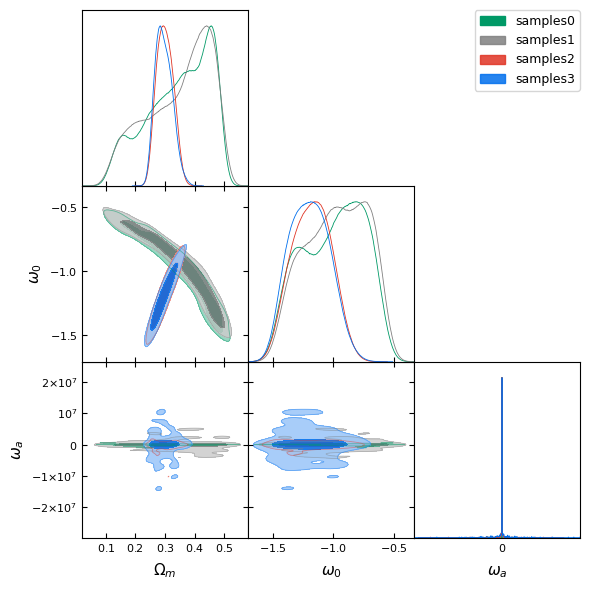

In [9]:
# Creating MCSamples objects for each dataset separately
samples_gd_sgc_snia = MCSamples(samples=samples_sgc_snia, names=['Omega_m', 'w0', 'w_a'], labels=['\\Omega_m', '\\omega_0', '\\omega_a'])
samples_gd_ngc_snia = MCSamples(samples=samples_ngc_snia, names=['Omega_m', 'w0', 'w_a'], labels=['\\Omega_m', '\\omega_0', '\\omega_a'])
samples_gd_sgc_bao = MCSamples(samples=samples_sgc_bao, names=['Omega_m', 'w0', 'w_a'], labels=['\\Omega_m', '\\omega_0', '\\omega_a'])
samples_gd_ngc_bao = MCSamples(samples=samples_ngc_bao, names=['Omega_m', 'w0', 'w_a'], labels=['\\Omega_m', '\\omega_0', '\\omega_a'])

# Plotting the combined likelihoods
g = plots.get_subplot_plotter(subplot_size=2)
g.triangle_plot([samples_gd_sgc_snia, samples_gd_ngc_snia, samples_gd_sgc_bao, samples_gd_ngc_bao], filled=True)
plt.show()

Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


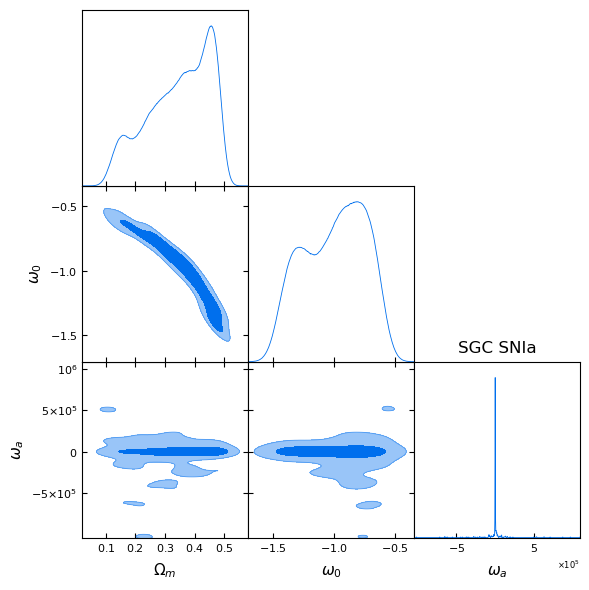

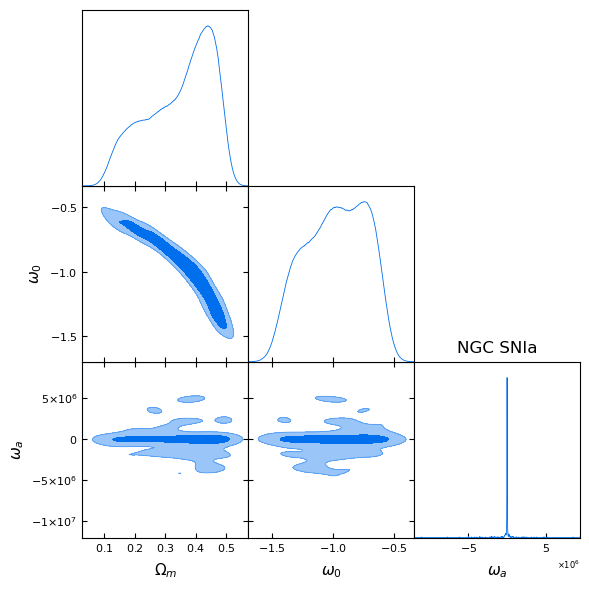

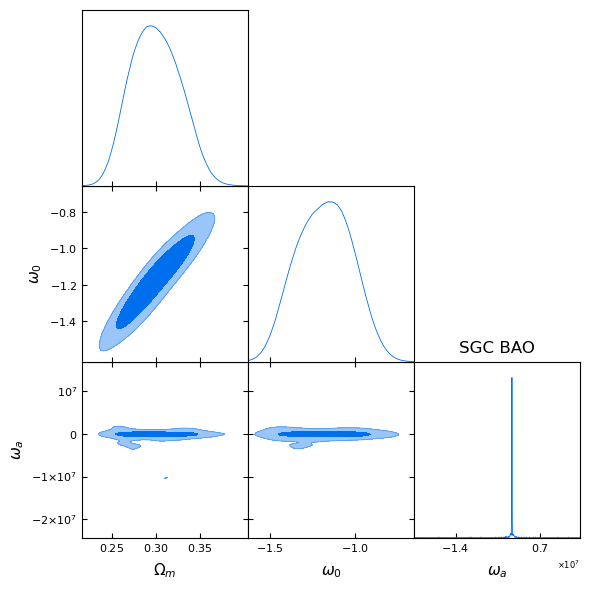

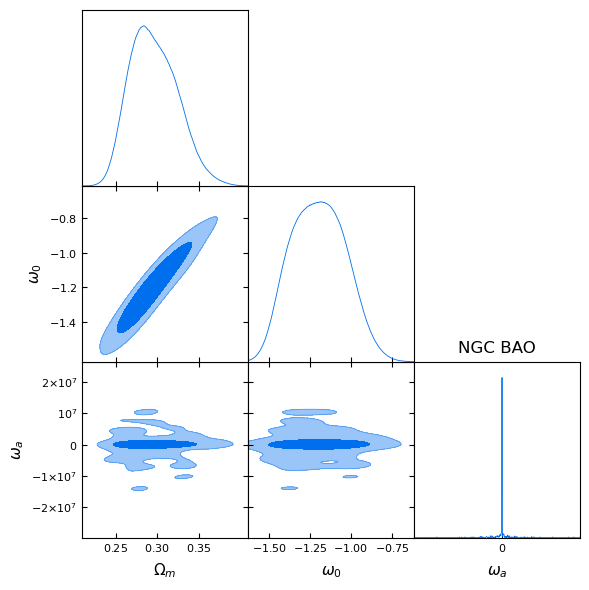

In [10]:
from getdist import MCSamples

# Creation of MCSamples objects for each dataset separately
samples_gd_sgc_snia = MCSamples(samples=samples_sgc_snia, names=['Omega_m', 'w0', 'w_a'], labels=['\\Omega_m', '\\omega_0', '\\omega_a'])
samples_gd_ngc_snia = MCSamples(samples=samples_ngc_snia, names=['Omega_m', 'w0', 'w_a'], labels=['\\Omega_m', '\\omega_0', '\\omega_a'])
samples_gd_sgc_bao = MCSamples(samples=samples_sgc_bao, names=['Omega_m', 'w0', 'w_a'], labels=['\\Omega_m', '\\omega_0', '\\omega_a'])
samples_gd_ngc_bao = MCSamples(samples=samples_ngc_bao, names=['Omega_m', 'w0', 'w_a'], labels=['\\Omega_m', '\\omega_0', '\\omega_a'])

# Ploting the separate triangle plots for all data

g = plots.get_subplot_plotter()

# Plot for SGC SNIa

g.triangle_plot(samples_gd_sgc_snia, filled=True)
plt.title("SGC SNIa")
plt.show()

# Plot for NGC SNIa

g.triangle_plot(samples_gd_ngc_snia, filled=True)
plt.title("NGC SNIa")
plt.show()

# Plot for SGC BAO

g.triangle_plot(samples_gd_sgc_bao, filled=True)
plt.title("SGC BAO")
plt.show()

# Plot for NGC BAO

g.triangle_plot(samples_gd_ngc_bao, filled=True)
plt.title("NGC BAO")
plt.show()

### Now, we define combined likelihood and proceed with the similar steps as before.
### The combined likelihood is simply the product of the individual likelihoods.
### In log space, this becomes a sum of the log-likelihoods.

In [11]:
# Combined Log-likelihood function

def log_likelihood_combined(params):
    """Calculate the combined log-likelihood for SNIa and BAO data in SGC and NGC."""
    ll_snia_sgc = log_likelihood_sgc(params)
    ll_snia_ngc = log_likelihood_ngc(params)
    ll_bao_sgc = log_likelihood_bao_sgc(params)
    ll_bao_ngc = log_likelihood_bao_ngc(params)

    return ll_snia_sgc + ll_snia_ngc + ll_bao_sgc + ll_bao_ngc

### MCMC sampling for the combined likelihood is given below.

In [12]:
# MCMC sampling for the combined likelihood
sampler_combined = emcee.EnsembleSampler(nwalkers, ndim, log_likelihood_combined)
sampler_combined.run_mcmc(pos, nsteps, progress=True)
samples_combined = sampler_combined.get_chain(discard=50, thin=15, flat=True)

# Creation of MCSamples objects for combined data
samples_gd_combined = MCSamples(samples=samples_combined, names=['Omega_m', 'omega_0'], labels=['\\Omega_m', '\\omega_0'])

# Ploting the combined triangle plot
g = plots.get_subplot_plotter()
g.triangle_plot([samples_gd_combined], filled=True)

plt.show()

100%|█████████████████████████████████████████| 200/200 [01:17<00:00,  2.59it/s]


Removed no burn in


WeightedSampleError: paramNames size (2) does not match number of parameters in samples (3)

In [33]:
# Importing packages
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
import emcee
import getdist
from getdist import plots, MCSamples

# Loading SGC and NGC SNIa data
data_sgc = np.loadtxt('z_flux_dflux-SGC.txt')
redshifts_sgc = data_sgc[:, 0]
fluxes_sgc = data_sgc[:, 1] 
errors_sgc = data_sgc[:, 2]

data_ngc = np.loadtxt('z_flux_dflux-NGC.txt')
redshifts_ngc = data_ngc[:, 0]
fluxes_ngc = data_ngc[:, 1] 
errors_ngc = data_ngc[:, 2]

# Loading SGC and NGC BAO data
data_bao_sgc = np.loadtxt('z_alpha_dalpha-SGC.txt')
redshifts_bao_sgc = data_bao_sgc[:, 0]
alphas_bao_sgc = data_bao_sgc[:, 1]
errors_bao_sgc = data_bao_sgc[:, 2]

data_bao_ngc = np.loadtxt('z_alpha_dalpha-NGC.txt')
redshifts_bao_ngc = np.loadtxt('z_alpha_dalpha-NGC.txt')
alphas_bao_ngc = data_bao_ngc[:, 1]
errors_bao_ngc = data_bao_ngc[:, 2]

# Constants
c = 3e5  # Speed of light in km/s
H0 = 67.6  # Hubble constant in km/s/Mpc
L_sun_conversion_factor = 3133273990.1869855

# Hubble parameter
def H_z(z, Omega_m, w0):
    return H0 * np.sqrt(Omega_m * (1 + z)**3 + (1 - Omega_m) * (1 + z)**(3 * (1 + w0)))

# Comoving distance
def comoving_distance(z, Omega_m, w0):
    integrand = lambda z_: 1 / H_z(z_, Omega_m, w0)
    if np.isscalar(z):
        return c * quad(integrand, 0, z)[0]
    return c * np.array([quad(integrand, 0, z_)[0] for z_ in z])

# Luminosity distance
def luminosity_distance(z, Omega_m, w0):
    return (1 + z) * comoving_distance(z, Omega_m, w0)


Omega_m_fid_AP = 0.3
w_0_fid_AP = -1.0
h_fid_AP = 0.7
r_d_fid = 147.78  # in Mpc, fiducial sound horizon

# Functions for the analysis
def vol_distance(z, Omega_m, w0, h):
    # Simplified volume distance calculation
    return c * z / (h * np.sqrt(Omega_m * (1 + z)**3 + (1 - Omega_m) * (1 + z)**(3 * (1 + w0))))

def r_d(Omega_m, h):
    # Simplified sound horizon calculation
    return r_d_fid * (h_fid_AP / h) * (Omega_m_fid_AP / Omega_m)**(0.5)

def alpha_vec(z, Omega_m, w0, h):
    non_fid = vol_distance(z, Omega_m, w0, h) / r_d(Omega_m, h)
    fid = vol_distance(z, Omega_m_fid_AP, w_0_fid_AP, h_fid_AP) / r_d(Omega_m_fid_AP, h_fid_AP)
    return (non_fid / fid).flatten()

# Log-likelihood functions

def log_likelihood_sgc(params):
    Omega_m, w0, w_a = params
    if Omega_m < 0.1 or Omega_m > 0.5 or w0 < -1.5 or w0 > -0.5:
        return -np.inf
    lum_distances = luminosity_distance(redshifts_sgc, Omega_m, w0)
    model_fluxes = L_sun_conversion_factor / (4 * np.pi * lum_distances**2.)
    sigma2 = errors_sgc ** 2
    return -0.5 * np.sum((fluxes_sgc - model_fluxes) ** 2 / sigma2 + np.log(2 * np.pi * sigma2))

def log_likelihood_ngc(params):
    Omega_m, w0, w_a = params
    if Omega_m < 0.1 or Omega_m > 0.5 or w0 < -1.5 or w0 > -0.5:
        return -np.inf
    lum_distances = luminosity_distance(redshifts_ngc, Omega_m, w0)
    model_fluxes = L_sun_conversion_factor / (4 * np.pi * lum_distances**2.)
    sigma2 = errors_ngc ** 2
    return -0.5 * np.sum((fluxes_ngc - model_fluxes) ** 2 / sigma2 + np.log(2 * np.pi * sigma2))
    
def log_likelihood_bao_sgc(params):
    Omega_m, w0, w_a, h = params
    alphas = alpha_vec(redshifts_bao_sgc, Omega_m, w0, h)
    sigma2 = errors_bao_sgc**2
    return -0.5 * np.sum((alphas_bao_sgc - alphas)**2 / sigma2 + np.log(2 * np.pi * sigma2))

def log_likelihood_bao_ngc(params):
    Omega_m, w0, w_a, h = params
    alphas = alpha_vec(redshifts_bao_ngc, Omega_m, w0, h).flatten()
    sigma2 = errors_bao_ngc**2
    return -0.5 * np.sum((alphas_bao_ngc - alphas)**2 / sigma2 + np.log(2 * np.pi * sigma2))

# MCMC settings
nwalkers = 100
nsteps = 200
ndim_snia = 3  # Omega_m, w0, w_a
ndim_bao = 4   # Omega_m, w0, w_a, h

# Initialize walkers for SNIa data (SGC and NGC)
pos = [np.array([0.3, -1.0, 0.0]) + 1e-4 * np.random.randn(ndim_snia) for i in range(nwalkers)]

# SGC MCMC sampling for SNIa data
sampler_sgc_snia = emcee.EnsembleSampler(nwalkers, ndim_snia, log_likelihood_sgc)
sampler_sgc_snia.run_mcmc(pos, nsteps, progress=True)
samples_sgc_snia = sampler_sgc_snia.get_chain(discard=25, thin=15, flat=True)

# Initialize walkers for BAO data (SGC and NGC)
pos_bao = [np.array([0.3, -1.0, 0.0, 0.7]) + 1e-4 * np.random.randn(ndim_bao) for i in range(nwalkers)]

# SGC MCMC sampling for BAO data
sampler_sgc_bao = emcee.EnsembleSampler(nwalkers, ndim_bao, log_likelihood_bao_sgc)
sampler_sgc_bao.run_mcmc(pos_bao, nsteps, progress=True)
samples_sgc_bao = sampler_sgc_bao.get_chain(discard=25, thin=15, flat=True)

# NGC MCMC sampling for SNIa data
sampler_ngc_snia = emcee.EnsembleSampler(nwalkers, ndim_snia, log_likelihood_sgc)
sampler_ngc_snia.run_mcmc(pos, nsteps, progress=True)
samples_ngc_snia = sampler_ngc_snia.get_chain(discard=25, thin=15, flat=True)

# NGC MCMC sampling for BAO data
sampler_ngc_bao = emcee.EnsembleSampler(nwalkers, ndim_bao, log_likelihood_bao_ngc)
sampler_ngc_bao.run_mcmc(pos_bao, nsteps, progress=True)
samples_ngc_bao = sampler_ngc_bao.get_chain(discard=25, thin=15, flat=True)

100%|█████████████████████████████████████████| 200/200 [00:52<00:00,  3.80it/s]
Traceback (most recent call last):
  File "/home/zorzeus/anaconda3/envs/mil/lib/python3.12/site-packages/emcee/ensemble.py", line 640, in __call__
    return self.f(x, *self.args, **self.kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_83159/55464758.py", line 101, in log_likelihood_bao_ngc
    return -0.5 * np.sum((alphas_bao_ngc - alphas)**2 / sigma2 + np.log(2 * np.pi * sigma2))
                          ~~~~~~~~~~~~~~~^~~~~~~~
ValueError: operands could not be broadcast together with shapes (7,) (21,) 


emcee: Exception while calling your likelihood function:
  params: [ 2.99844221e-01 -1.00006319e+00 -6.37768577e-05  7.00013408e-01]
  args: []
  kwargs: {}
  exception:


ValueError: operands could not be broadcast together with shapes (7,) (21,) 

Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


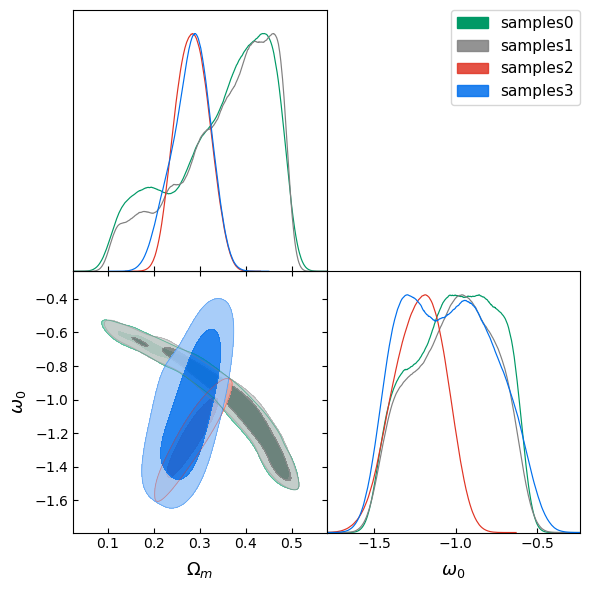

In [34]:
# Creating MCSamples objects for each dataset separately with only Omega_m and w0
samples_gd_sgc_snia = MCSamples(samples=samples_sgc_snia[:, :2], names=['Omega_m', 'w0'], labels=['\\Omega_m', '\\omega_0'])
samples_gd_ngc_snia = MCSamples(samples=samples_ngc_snia[:, :2], names=['Omega_m', 'w0'], labels=['\\Omega_m', '\\omega_0'])
samples_gd_sgc_bao = MCSamples(samples=samples_sgc_bao[:, :2], names=['Omega_m', 'w0'], labels=['\\Omega_m', '\\omega_0'])
samples_gd_ngc_bao = MCSamples(samples=samples_ngc_bao[:, :2], names=['Omega_m', 'w0'], labels=['\\Omega_m', '\\omega_0'])

# Plotting the combined likelihoods for Omega_m and w0
g = plots.get_subplot_plotter(subplot_size=3)
g.triangle_plot([samples_gd_sgc_snia, samples_gd_ngc_snia, samples_gd_sgc_bao, samples_gd_ngc_bao], filled=True)
plt.show()


Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


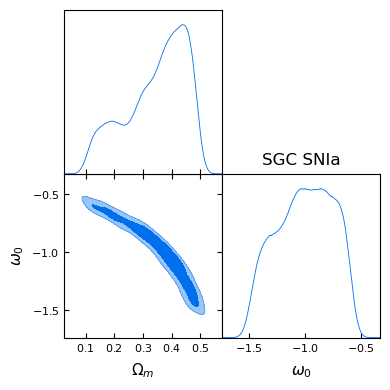

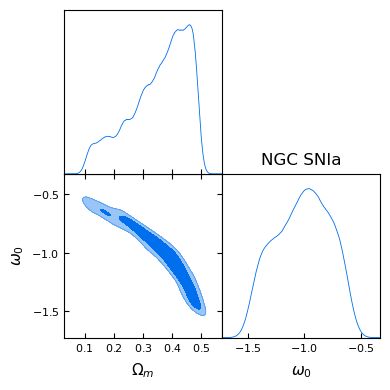

In [ ]:
# Creating MCSamples objects for each dataset separately with only Omega_m and w0
samples_gd_sgc_snia = MCSamples(samples=samples_sgc_snia[:, :2], names=['Omega_m', 'w0'], labels=['\\Omega_m', '\\omega_0'])
samples_gd_ngc_snia = MCSamples(samples=samples_ngc_snia[:, :2], names=['Omega_m', 'w0'], labels=['\\Omega_m', '\\omega_0'])
samples_gd_sgc_bao = MCSamples(samples=samples_sgc_bao[:, :2], names=['Omega_m', 'w0'], labels=['\\Omega_m', '\\omega_0'])
samples_gd_ngc_bao = MCSamples(samples=samples_ngc_bao[:, :2], names=['Omega_m', 'w0'], labels=['\\Omega_m', '\\omega_0'])

# Ploting the separate triangle plots for all data

g = plots.get_subplot_plotter()

# Plot for SGC SNIa

g.triangle_plot(samples_gd_sgc_snia, filled=True)
plt.title("SGC SNIa")
plt.show()

# Plot for NGC SNIa

g.triangle_plot(samples_gd_ngc_snia, filled=True)
plt.title("NGC SNIa")
plt.show()

# Plot for SGC BAO

g.triangle_plot(samples_gd_sgc_bao, filled=True)
plt.title("SGC BAO")
plt.show()

# Plot for NGC BAO

g.triangle_plot(samples_gd_ngc_bao, filled=True)
plt.title("NGC BAO")
plt.show()